In [1]:
import pandas as pd

In [12]:
import math
import random
import numpy as np
import sklearn
import sklearn.ensemble
import pandas as pd
import matplotlib.pyplot as plt
import tpot

In [119]:
data = pd.read_pickle("../raw_data/2d_mat_dataset_raw.pkl")
data = data.drop(columns=["2dm_id (unitless)", "formula", "atoms_object (unitless)", "potcars (unitless)", "is_hubbard (unitless)", "is_bandgap_direct (unitless)", "energy_per_atom (eV)", "is_metal (unitless)",
                          "decomposition_energy (eV/atom)"]).dropna().drop(columns=["discovery_process (unitless)"])
#data = data[data["discovery_process (unitless)"] == "top-down"].drop(columns=["discovery_process (unitless)"])
data

,exfoliation_energy_per_atom (eV/atom),energy_vdw_per_atom (eV/atom),total_magnetization (Bohr Magneton),bandgap (eV),ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
0,0.234617,-3.361686,2.487400e-01,0.0000,31.666667,134.682409,186.333333,14.246667,76.737935,1524.340000,...,2.0,2.0,0.133,0.0277,147.0,146.0,171.0,284.0,2826.915883,0.557
1,0.210645,-2.186996,7.488541e-01,0.0000,54.333333,201.000000,277.333333,32.133333,132.138000,1909.333333,...,2.0,5.0,0.192,18.0000,206.0,247.0,252.0,370.3,1620.000000,6.600
2,0.095794,-2.231434,-0.000000e+00,0.9814,48.500000,149.000000,228.000000,16.350000,118.220000,1223.912000,...,2.0,3.0,0.128,0.2050,180.0,189.0,215.0,403.5,818.000000,2.900
3,-0.055818,-4.469708,0.000000e+00,0.0000,25.333333,144.569212,218.666667,15.600000,55.616667,1787.400000,...,1.0,3.0,0.251,0.0089,175.0,182.0,207.0,305.2,206.000000,2.180
5,0.084831,-3.107710,0.000000e+00,1.1619,50.000000,145.159728,237.666667,19.900000,118.292980,1696.000000,...,1.0,5.0,0.238,0.4490,198.0,204.0,234.0,296.3,3289.214936,5.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976,0.059848,-4.146506,6.423405e+00,0.0000,35.666667,139.166667,232.666667,12.650000,82.560833,2449.666667,...,2.0,4.0,0.201,3.0000,204.0,199.0,223.0,291.2,2610.000000,5.500
6347,0.113072,-4.245431,1.500000e-05,0.0000,47.000000,133.000000,222.000000,12.300000,113.572000,2408.912000,...,1.0,3.0,0.133,0.2050,180.0,189.0,215.0,275.4,2680.000000,2.900
6348,0.125031,-3.856898,2.000000e-07,0.0000,56.000000,139.500000,227.000000,12.800000,137.027500,2529.050000,...,1.0,4.0,0.133,0.5200,190.0,182.0,229.0,275.4,2680.000000,3.770
6349,0.108621,-4.459145,2.050000e-05,0.0000,47.000000,133.000000,222.000000,12.300000,113.572000,2408.912000,...,1.0,3.0,0.133,0.2050,180.0,189.0,215.0,275.4,2680.000000,2.900


In [120]:
random.seed(1234)
np.random.seed(1234)
data_train, data_test = sklearn.model_selection.train_test_split(data, test_size=0.2)
mean, std = data_train.mean(), data_train.std()

data_train_scaled = (data_train - mean) / std
data_test_scaled = (data_test - mean) / std

In [121]:
model = tpot.TPOTRegressor(
    generations=None,
    population_size=100,
    max_eval_time_mins=1/60,
    max_time_mins=10,
    cv=10,
    verbosity=2,
    scoring="neg_root_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=-1,
    random_state=1234
)

In [122]:
#newmod = model
newmod

TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

In [123]:
model = sklearn.ensemble.GradientBoostingRegressor(n_estimators=200, max_depth=5)

In [160]:
target = "bandgap (eV)"
train_x = np.nan_to_num(data_train_scaled.drop(columns=[target]).to_numpy())
train_y = np.nan_to_num(data_train_scaled[target].to_numpy().ravel())

test_x = np.nan_to_num(data_test_scaled.drop(columns=[target]).to_numpy())
test_y = np.nan_to_num(data_test_scaled[target].to_numpy().ravel())

model.fit(train_x, train_y)

GradientBoostingRegressor(max_depth=5, n_estimators=200)

In [161]:
def unscale(arr):
    return arr * std[target] + mean[target]
    
train_pred_y = model.predict(train_x)
test_pred_y = model.predict(test_x[:340,:])

In [162]:
models = {}

models["r1_1term"] = lambda df: -7.517588190691672e-03 + 3.019120658205411e-01 * (df["ave:fusion_enthalpy"] - df["ave:electron_affinity"])
models["r1_2term"] = lambda df: -4.220354429619663e-01 + 3.043650335588696e-01 * np.exp(df["sum:gs_energy"]) + \
                                 3.290126411913264e-01 * (df["ave:fusion_enthalpy"] - df["ave:electron_affinity"])
models["r2_1term"] = lambda df: -4.730850253495772e-01 + 3.491171896552910e-01 * (np.exp(df["sum:gs_energy"]) + (df["ave:fusion_enthalpy"] - df["ave:electron_affinity"]))

data_train_scaled_sisso = data_train_scaled.copy()
data_test_scaled_sisso = data_test_scaled.copy()
for key,fun in models.items():
    data_train_scaled_sisso[key] = fun(data_train_scaled_sisso)
    data_test_scaled_sisso[key] = fun(data_test_scaled_sisso)

data_train_scaled_sisso.head()

,exfoliation_energy_per_atom (eV/atom),energy_vdw_per_atom (eV/atom),total_magnetization (Bohr Magneton),bandgap (eV),ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,...,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability,r1_1term,r1_2term,r2_1term
1516,-0.479635,-0.311201,2.957530,-0.282886,-0.838933,-0.674579,-1.656669,-0.266261,-0.821420,-0.284481,...,-0.304808,-0.991026,-1.025982,-1.344255,-0.641580,0.716255,-0.840521,-0.539790,-0.842870,-0.905954
47,-0.425963,0.764286,-0.353991,0.682514,-0.620620,-1.091742,-0.253270,-0.543328,-0.600563,0.844793,...,-0.300745,0.579815,0.269250,0.317746,1.527564,0.475414,0.045432,0.315668,0.318161,0.345682
1783,-0.314773,0.031836,2.294953,-0.554272,0.097699,0.193261,0.263771,0.436272,0.031331,-0.293837,...,-0.300745,0.579815,0.269250,0.582155,-0.591600,0.475414,0.052597,-0.353465,-0.318780,-0.322252
4429,0.091167,-1.074093,0.968450,1.596636,-1.162241,-0.196250,-1.179916,-0.586454,-1.151220,-1.088354,...,-0.304858,-0.784336,-0.896459,-0.928755,-0.969450,-0.965801,-0.752750,-0.057017,-0.419143,-0.465132
4878,-0.143386,0.115064,1.301939,2.090177,-1.047387,-0.656519,-1.789622,-0.088560,-1.013731,-1.359636,...,-0.304808,-0.991026,-1.025982,-1.344255,-0.715551,0.716255,-0.840521,-0.708034,-0.853709,-0.902632


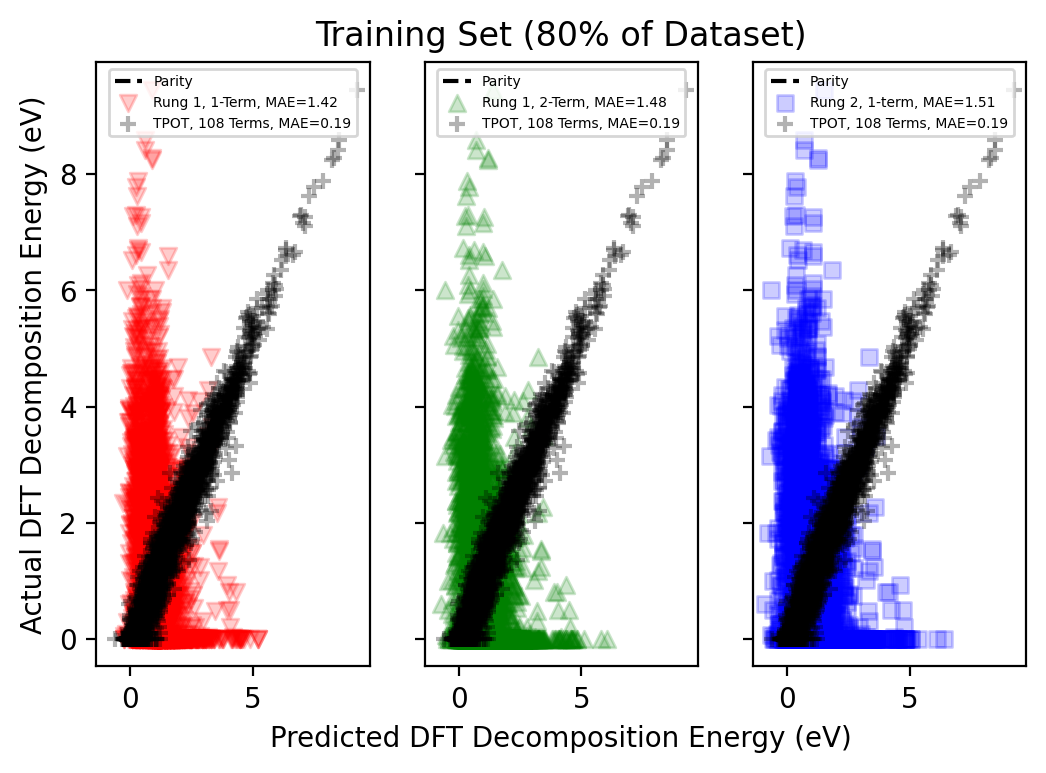

In [163]:
tpot_mae =  np.round(sklearn.metrics.mean_absolute_error(y_true=unscale(train_y), y_pred=unscale(train_pred_y)),2)
r1_1t_mae = np.round(sklearn.metrics.mean_absolute_error(y_true=unscale(train_y), y_pred=unscale(data_train_scaled_sisso["r1_1term"])),2)
r1_2t_mae = np.round(sklearn.metrics.mean_absolute_error(y_true=unscale(train_y), y_pred=unscale(data_train_scaled_sisso["r1_2term"])),2)
r2_1t_mae = np.round(sklearn.metrics.mean_absolute_error(y_true=unscale(train_y), y_pred=unscale(data_train_scaled_sisso["r2_1term"])),2)

plt.rcParams["figure.dpi"]=200
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True)
ax1.set_ylabel("Actual DFT Decomposition Energy (eV)")
ax2.set_xlabel("Predicted DFT Decomposition Energy (eV)")


    
ax1.scatter(x=unscale(data_train_scaled_sisso["r1_1term"]), y=unscale(train_y), marker="v", color="red",alpha=0.2, label=f"Rung 1, 1-Term, MAE={r1_1t_mae}")
ax2.scatter(x=unscale(data_train_scaled_sisso["r1_2term"]), y=unscale(train_y), marker="^", color="green", alpha=0.2, label=f"Rung 1, 2-Term, MAE={r1_2t_mae}")
ax3.scatter(x=unscale(data_train_scaled_sisso["r2_1term"]), y=unscale(train_y), marker="s", color="blue", alpha=0.2, label=f"Rung 2, 1-term, MAE={r2_1t_mae}")
for ax in (ax1, ax2, ax3):
    ax.scatter(x=unscale(train_pred_y), y=unscale(train_y), color="black", alpha=0.3, marker="+", label=f"TPOT, 108 Terms, MAE={tpot_mae}")
    ax.plot([0, 3], [0, 3], color="black", linestyle="--", label="Parity")
    
for ax in (ax1, ax2, ax3):
    ax.legend(prop={"size":5}, loc="upper center")

ax2.set_title("Training Set (80% of Dataset)")
plt.show()

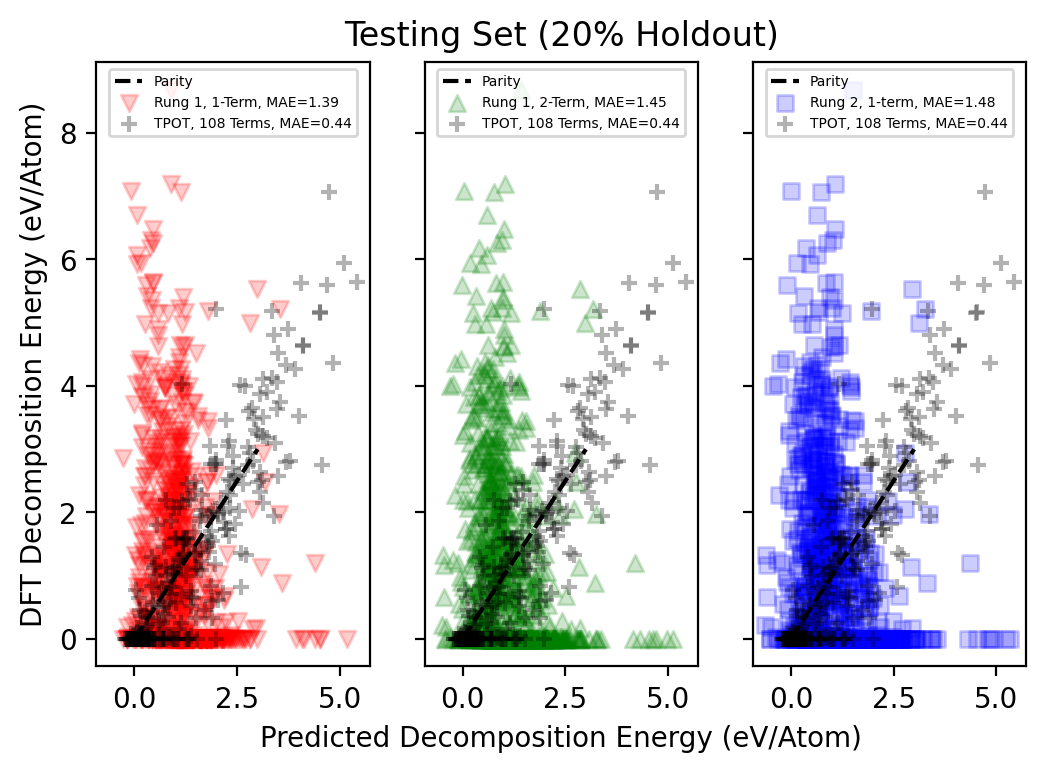

In [164]:
tpot_mae =  np.round(sklearn.metrics.mean_absolute_error(y_true=unscale(test_y[:340]), y_pred=unscale(test_pred_y)),2)
r1_1t_mae = np.round(sklearn.metrics.mean_absolute_error(y_true=unscale(test_y), y_pred=unscale(data_test_scaled_sisso["r1_1term"])),2)
r1_2t_mae = np.round(sklearn.metrics.mean_absolute_error(y_true=unscale(test_y), y_pred=unscale(data_test_scaled_sisso["r1_2term"])),2)
r2_1t_mae = np.round(sklearn.metrics.mean_absolute_error(y_true=unscale(test_y), y_pred=unscale(data_test_scaled_sisso["r2_1term"])),2)

plt.rcParams["figure.dpi"]=200
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True)
ax1.set_ylabel("DFT Decomposition Energy (eV/Atom)")
ax2.set_xlabel("Predicted Decomposition Energy (eV/Atom)")
 
ax1.scatter(x=unscale(data_test_scaled_sisso["r1_1term"]), y=unscale(test_y), marker="v", color="red",alpha=0.2, label=f"Rung 1, 1-Term, MAE={r1_1t_mae}")
ax2.scatter(x=unscale(data_test_scaled_sisso["r1_2term"]), y=unscale(test_y), marker="^", color="green", alpha=0.2, label=f"Rung 1, 2-Term, MAE={r1_2t_mae}")
ax3.scatter(x=unscale(data_test_scaled_sisso["r2_1term"]), y=unscale(test_y), marker="s", color="blue", alpha=0.2, label=f"Rung 2, 1-term, MAE={r2_1t_mae}")
for ax in (ax1, ax2, ax3):
    ax.scatter(x=unscale(test_pred_y[:340]), y=unscale(test_y[:340]), color="black", alpha=0.3, marker="+", label=f"TPOT, 108 Terms, MAE={tpot_mae}")
    ax.plot([0, 3], [0, 3], color="black", linestyle="--", label="Parity")

ax2.set_title("Testing Set (20% Holdout)")
for ax in (ax1, ax2, ax3):
    ax.legend(prop={"size":5}, loc="upper center")

plt.show()

In [165]:
imps = list(zip(model.feature_importances_, data_train_scaled.drop(columns=[target]).columns))
sorted(imps, key=lambda i: -i[0])

[(0.22912415015475804, 'total_magnetization (Bohr Magneton)'),
 (0.09963689813528821, 'ave:boiling_point'),
 (0.03622024963541163, 'max:en_pauling'),
 (0.03253497683276793, 'var:en_pauling'),
 (0.028665860076960592, 'var:electron_negativity'),
 (0.026005535770520068, 'max:heat_capacity_molar'),
 (0.024690230629371538, 'ave:first_ion_en'),
 (0.020239624596536384, 'energy_vdw_per_atom (eV/atom)'),
 (0.01677269604206667, 'ave:num_unfilled'),
 (0.016468420326932152, 'ave:mendeleev_number'),
 (0.015933222574635253, 'exfoliation_energy_per_atom (eV/atom)'),
 (0.015423331951526446, 'ave:en_ghosh'),
 (0.015288635890658936, 'ave:en_allen'),
 (0.01374474424456179, 'ave:density'),
 (0.012991127657161325, 'var:num_d_valence'),
 (0.01173423029186494, 'var:num_p_unfilled'),
 (0.011232860959003927, 'ave:num_p_valence'),
 (0.010695631933258553, 'ave:vdw_radius_alvarez'),
 (0.009247874791220958, 'ave:gs_bandgap'),
 (0.008884400892155865, 'var:electron_affinity'),
 (0.008058133339044902, 'ave:evaporatio